<a href="https://colab.research.google.com/github/Hongyac/Nyu-Deep-Learning-Fall-2022/blob/main/dlf22_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import sys

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Prepare the data

In [ ]:
SEED = 213

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data


## Data Argumentation Strategy I:

In [ ]:
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

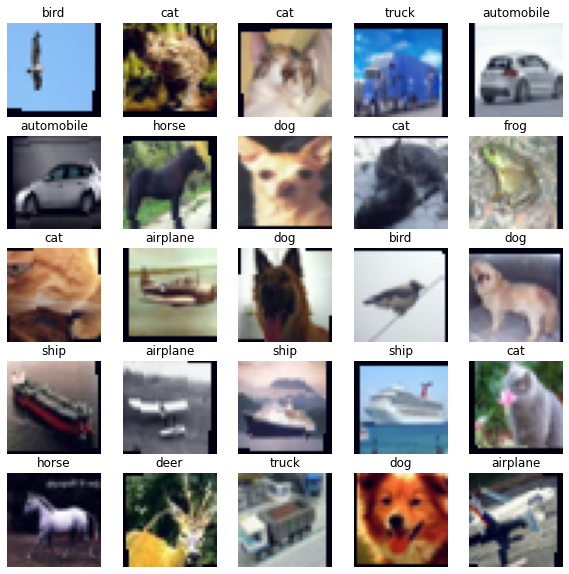

In [ ]:
plot_images(images, labels, classes, normalize = True)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
# Define the batch size and iterator

BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## ResNet 18 Modified

In [ ]:
# Define Resnet: Modified source code from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
  return ResNet(BasicBlock, [2, 1, 1, 1])



In [ ]:
# define first device:

device_1 = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc_1 = 0  # best test accuracy
start_epoch_1 = 0  # start from epoch 0 or last checkpoint epoch




In [ ]:
# Data, modified source code from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
print('==> Preparing data..')
transform_train_1 = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_1 = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_1)
trainloader = torch.utils.data.DataLoader(
    trainset_1, batch_size=128, shuffle=True, num_workers=2)

testset_1 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test_1)
testloader = torch.utils.data.DataLoader(
    testset_1, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Done!")

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Done!


In [ ]:
# Model (Modified source code from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)
print('==> Building model..')

net_1 = ResNet18()
net_1 = net_1.to(device_1)
if device_1 == 'cuda':
    net_1 = torch.nn.DataParallel(net_1)
    cudnn.benchmark = True


criterion_1 = nn.CrossEntropyLoss()

optimizer_1_SGD = optim.SGD(net_1.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
optimizer_1_Adam= optim.Adam(net_1.parameters(), lr=1e-3, weight_decay=5e-4)

scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1_Adam, T_max=200)

print("Done!")

==> Building model..
Done!


In [ ]:
trainable_params_1 = sum(pa.numel() for pa in net_1.parameters() if pa.requires_grad)
model_1_info = "The total number of trainable parameters in this model: {n:d}"
model_1_info = model_1_info.format(n=trainable_params_1)
print(model_1_info)

The total number of trainable parameters in this model: 4977226


In [ ]:
# Training (Modified source code from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)
train_loss_history_1 = []
test_loss_history_1 = []

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net_1.train()
    train_loss = 0.0
    correct    = 0
    total      = 0
    for batch_idx, (inputs, targets) in enumerate(train_iterator):
        inputs, targets = inputs.to(device_1), targets.to(device_1)
        optimizer_1_Adam.zero_grad()
        outputs = net_1(inputs)
        loss = criterion_1(outputs, targets)
        loss.backward()
        optimizer_1_Adam.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    train_info_1 = "Train Loss: {loss:.9f},|".format(loss=train_loss/(batch_idx+1))
    train_info_2 = " Train Acc: {acc:.9f},|".format(acc=100.*correct/total)
    train_info_3 = " Correct:{corr:5d}/Total:{tot:5d}".format(corr=correct, tot=total)
    train_info = train_info_1 + train_info_2 + train_info_3
    print(train_info)


def test(epoch):
    global best_acc_1
    net_1.eval()
    test_loss = 0
    correct   = 0
    total     = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_iterator):
            inputs, targets = inputs.to(device_1), targets.to(device_1)
            outputs = net_1(inputs)
            loss = criterion_1(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        test_loss_history_1.append(test_loss)
        test_info_1 = "Test Loss: {loss:.9f},|".format(loss=test_loss/(batch_idx+1))
        test_info_2 = " Test Acc: {acc:.9f},|".format(acc=100.*correct/total)
        test_info_3 = " Correct:{corr:5d}/Total:{tot:5d}".format(corr=correct, tot=total)
        test_info = test_info_1 + test_info_2 + test_info_3
        print(test_info)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc_1:
        print('Saving..')
        state = {
            'net': net_1.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc_1 = acc


for epoch in range(start_epoch_1, start_epoch_1+200):
    train(epoch)
    test(epoch)
    scheduler_1.step()


Epoch: 0
Train Loss: 1.450633466,| Train Acc: 46.728888889,| Correct:21028/Total:45000
Test Loss: 1.265830696,| Test Acc: 54.100000000,| Correct: 5410/Total:10000
Saving..

Epoch: 1
Train Loss: 0.993716260,| Train Acc: 64.393333333,| Correct:28977/Total:45000
Test Loss: 1.087069246,| Test Acc: 62.520000000,| Correct: 6252/Total:10000
Saving..

Epoch: 2
Train Loss: 0.817014199,| Train Acc: 71.115555556,| Correct:32002/Total:45000
Test Loss: 0.980117114,| Test Acc: 65.880000000,| Correct: 6588/Total:10000
Saving..

Epoch: 3
Train Loss: 0.692807958,| Train Acc: 75.728888889,| Correct:34078/Total:45000
Test Loss: 0.750289224,| Test Acc: 73.760000000,| Correct: 7376/Total:10000
Saving..

Epoch: 4
Train Loss: 0.620365165,| Train Acc: 78.342222222,| Correct:35254/Total:45000
Test Loss: 0.671041223,| Test Acc: 76.700000000,| Correct: 7670/Total:10000
Saving..

Epoch: 5
Train Loss: 0.566392900,| Train Acc: 80.377777778,| Correct:36170/Total:45000
Test Loss: 0.684626999,| Test Acc: 77.090000000

In [ ]:
best_acc_1

93.1

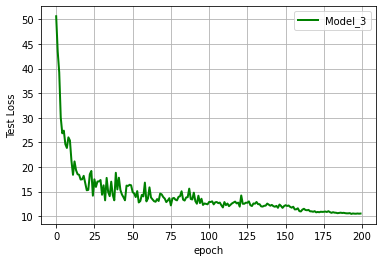

In [ ]:
num_epochs = 200
plt.plot(range(num_epochs),test_loss_history_1,'-',color='g',
         linewidth=2,label='Model_3')
# plt.plot(range(num_epochs),te,'-',linewidth=2,label='Model 1')
plt.xlabel('epoch')
plt.ylabel('Test Loss')
plt.grid(True)
plt.legend()

## Modified ResNet-18 again:

In [ ]:
# Define Resnet: Modified source code from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
  return ResNet(BasicBlock, [2, 1, 1, 1])

